# LIDAR data greenspace detector

# Hackday CUSP 12-02-17

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import requests
from IPython.display import HTML
import geopandas as gpd
from fiona.crs import from_epsg
from shapely.geometry import Point
import os
import seaborn
%pylab inline

import statsmodels.formula.api as smf

import seaborn as sns
sns.set_style('whitegrid')

PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib
/home/cusp/dcr346/PUIdata


In [2]:
import laspy
from laspy.file import File
import scipy
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata

In [3]:
data15 = File('2015 T_316000_233000 - 15m_v2.las', mode='r')
data15.read
points15 = np.array([data15.x, data15.y]).T
points15

array([[ 316285.01170923,  233454.48233112],
       [ 316285.11170923,  233455.15133112],
       [ 316285.37170923,  233456.89933112],
       ..., 
       [ 316283.54870923,  233452.72433112],
       [ 316283.57770923,  233452.87133112],
       [ 316283.58770923,  233452.26033112]])

## Defining the grid

In [19]:
grid_x, grid_y = np.mgrid[data15.x.min() : data15.x.max() : 0.01, data15.y.min() : data15.y.max() : 0.01]

In [20]:
grid_y

array([[ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       ..., 
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112]])

## Creat a grid of Z (height) values

In [21]:
grid_z15 = griddata(points15, data15.z, (grid_x, grid_y), method = 'nearest')

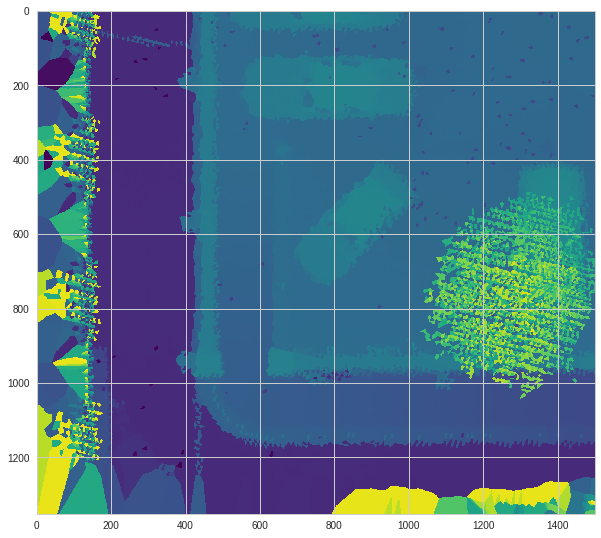

In [132]:
plt.figure(figsize=(10,10))
plt.imshow(grid_z15, cmap='viridis')
plt.show()

In [23]:
data07 = File('2007 316000_233500 - 15m_v2.las', mode='r')
data07.read
points07 = np.array([data07.x, data07.y]).T
points07

array([[ 316285.27435828,  233460.60167551],
       [ 316285.25835828,  233460.56667551],
       [ 316285.28035828,  233460.52467551],
       ..., 
       [ 316272.11735828,  233458.02467551],
       [ 316272.03035828,  233457.51267551],
       [ 316271.94135828,  233457.00867551]])

In [24]:
grid_z07 = griddata(points07, data07.z, (grid_x, grid_y), method = 'nearest')

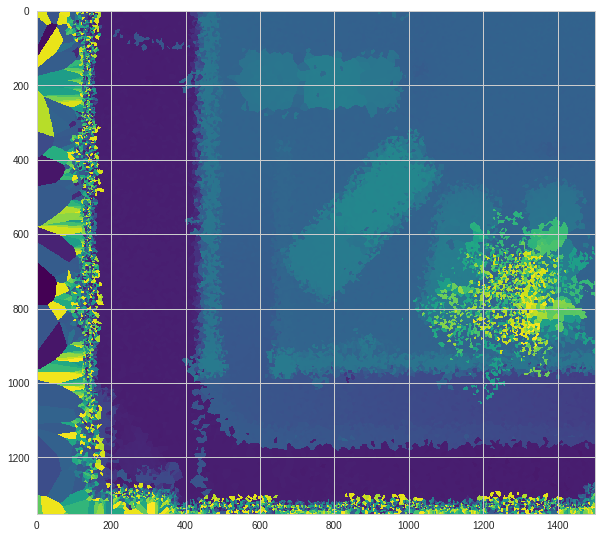

In [133]:
plt.figure(figsize=(10,10))
plt.imshow(grid_z07, cmap='viridis')
plt.show()

## Grid of change of Z values

In [39]:
change = np.abs(grid_z15 - grid_z07)
change

array([[  9.27356250e+00,   9.27356250e+00,   9.27356250e+00, ...,
          2.35625000e-02,   2.35625000e-02,   2.35625000e-02],
       [  9.27356250e+00,   9.27356250e+00,   9.27356250e+00, ...,
          2.35625000e-02,   2.35625000e-02,   2.35625000e-02],
       [  9.27356250e+00,   9.27356250e+00,   9.27356250e+00, ...,
          2.35625000e-02,   2.35625000e-02,   2.35625000e-02],
       ..., 
       [  2.60143750e+00,   2.60143750e+00,   2.60143750e+00, ...,
          5.62500000e-04,   5.62500000e-04,   5.62500000e-04],
       [  2.60143750e+00,   2.60143750e+00,   2.60143750e+00, ...,
          5.62500000e-04,   5.62500000e-04,   5.62500000e-04],
       [  2.60143750e+00,   2.60143750e+00,   2.60143750e+00, ...,
          5.62500000e-04,   5.62500000e-04,   5.62500000e-04]])

In [40]:
change.shape

(1352, 1500)

In [41]:
change.std()

2.2035707362848043

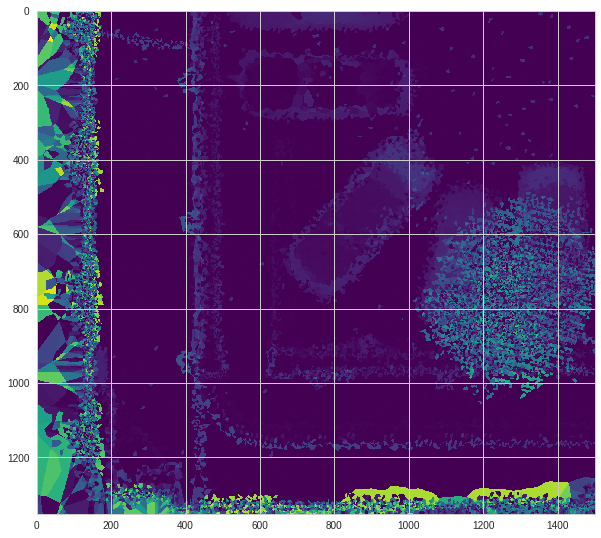

In [134]:
plt.figure(figsize=(10,10))
plt.imshow(change, cmap='viridis')
#plt.ylim(600,800)
#plt.xlim(1200,1400)
plt.show()

## Defining growth of green spaces using sliced dataset of "tree"

In [61]:
tree = change[600:801,1200:1401]
tree

array([[ 2.8984375,  2.8984375,  2.8984375, ...,  3.0465625,  3.0465625,
         3.0465625],
       [ 2.8984375,  2.8984375,  2.8984375, ...,  3.0465625,  3.0465625,
         3.0465625],
       [ 0.1174375,  0.1174375,  2.8984375, ...,  3.0465625,  3.0465625,
         3.0465625],
       ..., 
       [ 2.2105625,  3.4534375,  3.4534375, ...,  0.1565625,  0.1565625,
         0.7034375],
       [ 3.4534375,  3.4534375,  3.4534375, ...,  0.1565625,  0.7034375,
         0.7034375],
       [ 3.4224375,  3.4224375,  3.4534375, ...,  0.1565625,  0.7034375,
         0.7034375]])

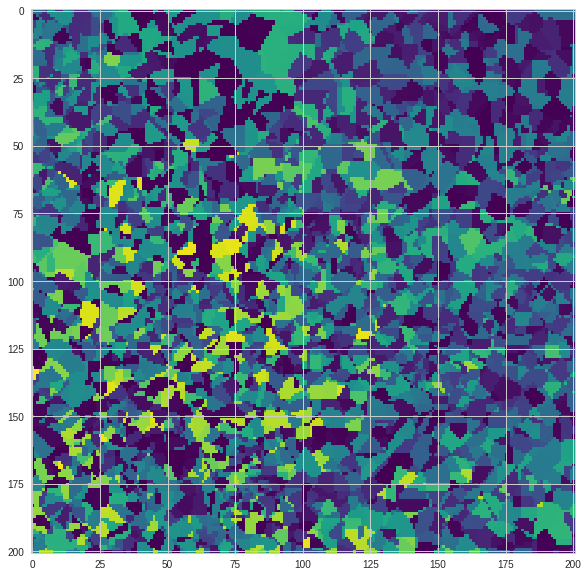

In [135]:
plt.figure(figsize=(10,10))
plt.imshow(tree, cmap='viridis')
plt.show()

In [97]:
print("mean of all data change: {}\nstd of all data change: {}\nmin of all data change: {}\nmax of all data change: {}".format(change.mean(), change.std(), change.min(), change.max()))

mean of all data change: 1.06224854561144
std of all data change: 2.2035707362848043
min of all data change: 0.0004374999999967599
max of all data change: 12.733562499999998


In [96]:
print("mean of green growth: {}\nstd of green growth: {}\nmin of green growth: {}\nmax of green growth: {}".format(tree.mean(), tree.std(), tree.min(), tree.max()))

mean of green growth: 2.6810401831019033
std of green growth: 2.129687870791856
min of green growth: 0.0004374999999967599
max of green growth: 8.210562499999998


## Defining threshold for green growth

1. smothing the values
2. remove under 2 std from the mean
3. assess again!

In [128]:
# smoothing

from scipy.ndimage.filters import uniform_filter

change_smooth = uniform_filter(change, size=(50), mode='constant')

In [129]:
change_smooth.shape

(1352, 1500)

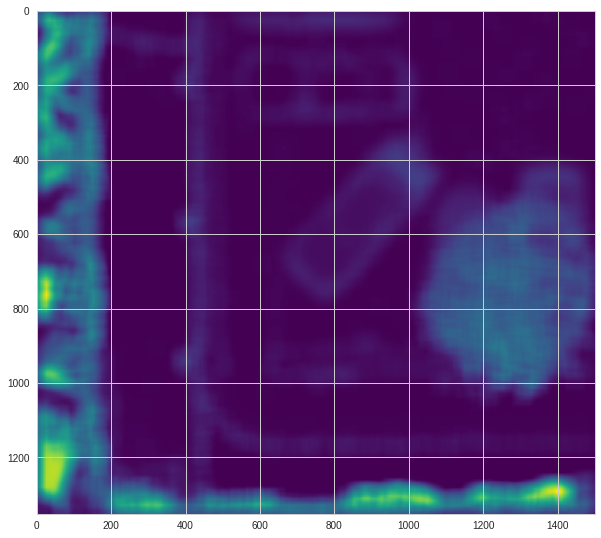

In [136]:
plt.figure(figsize=(10,10))
plt.imshow(change_smooth, cmap='viridis')
plt.show()

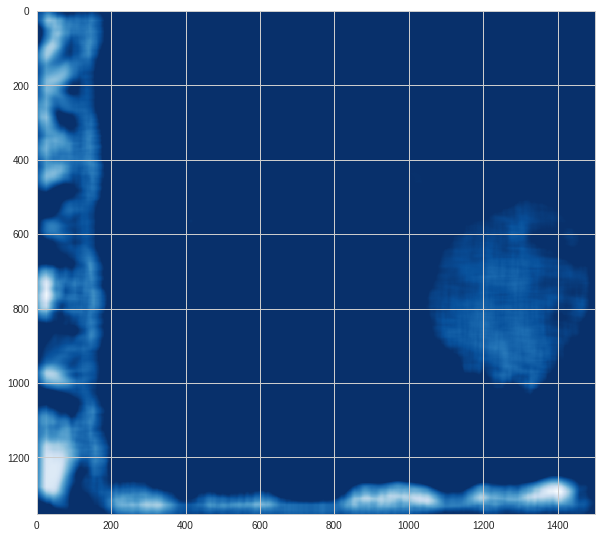

In [138]:
plt.figure(figsize=(10,10))
greenspace = change_smooth-(change_smooth.mean()+change_smooth.std()/2)
greenspace = greenspace.clip(min=0)
plt.imshow(greenspace, cmap='Blues_r')